In [108]:
import numpy as np
try:
    import matplotlib.pyplot as mp
except:
    mp = None


def sigmoid(x):
    return 1/(1+np.exp(-x))


def deriv_sigmoid(x):
    a = sigmoid(x)
    return a * (1 - a)


def tanh(x):
    ep = np.exp(x)
    en = np.exp(-x)
    return (ep - en)/(ep + en)


def deriv_tanh(x):
    a = tanh(x)
    return 1 - (a * a)


def relu(x):
    ret = 0
    #fixme should map to compare
    if x > 0:
        ret = x
    elif type(x) is np.ndarray:
        ret = np.zeros(x.shape)
    return ret

def deriv_relu(x):
    ret = 0
    if z < 0:
        ret = 0.01
    else:
        ret = 1

def leaky_relu(x):
    ret = 0.01 * x
    #fixme should map to compare
    if x > 0:
        ret = x
    elif type(x) is np.ndarray:
        ret = np.ones(x.shape)*0.01
    return ret


class MultiLayerPerceptron(object):

    functions = {
        "sigmoid": {"function": sigmoid, "derivative": deriv_sigmoid},
        "tanh": {"function": tanh, "derivative": deriv_tanh},
        "relu": {"function": relu, "derivative": deriv_relu},
    }

    def __init__(self, L=1, n=None, g=None, alpha=0.01, lambd=0):
        """Initializes network geometry and parameters
        :param L: number of layers including output and excluding input. Defaut 1.
        :type L: int
        :param n: list of number of units per layer including input. Default [2, 1].
        :type n: list
        :param g: list of activation functions name per layer excluding input.
            Possible names are: "sigmoid", "tanh". Default ["sigmoid"].
        :type g: list
        :param alpha: learning rate. Default 0.01.
        """
        w_rand_factor = 1
        self._L = L
        if n is None:
            n = [2, 1]
        self._n = n
        if g is None:
            g = [MultiLayerPerceptron.functions["sigmoid"]]
        else:
            g = [MultiLayerPerceptron.functions[fct] for fct in g]
        self._g = [None] + g
        self._W = [None] + [np.random.randn(n[l+1], n[l])*w_rand_factor for l in range(L)]
        self._b = [None] + [np.zeros((n[l+1], 1)) for l in range(L)]
        assert(len(self._g) == len(self._W))
        assert(len(self._g) == len(self._b))
        assert(len(self._g) == len(self._n))
        self._A = None
        self._X = None
        self._Y = None
        self._Z = None
        self._m = 0
        self._alpha = alpha
        self._lambda = lambd

    def set_all_input_examples(self, X, m=1):
        """Set the input examples.

        :param X: matrix of dimensions (n[0], m). Accepts also a list (len m) of lists (len n[0])
        :param m: number of training examples.
        :type m: int
        """
        if type(X) is list:
            assert(len(X) == m)
            self._X = np.matrix(X).T
        else:
            assert(X.shape == (self._n[0], self._m))
            self._X = X
        self._m = m
        assert((self._m == m) or (self._m == 0))
        self._m = m

    def set_all_expected_output_examples(self, Y, m=1):
        """Set the output examples

        :param Y: matrix of dimensions (n[L], m). Accepts also a list (len m) of lists (len n[L])
        :param m: number of training examples.
        :type m: int
        """
        if type(Y) is list:
            assert(len(Y) == m)
            self._Y = np.matrix(Y).T
        else:
            assert(Y.shape == (self._n[self._L], self._m))
            self._Y = Y
        assert((self._m == m) or (self._m == 0))
        self._m = m

    def set_all_training_examples(self, X, Y, m=1):
        """Set all training examples

        :param X: matrix of dimensions (n[0], m). Accepts also a list (len m) of lists (len n[0])
        :param Y: matrix of dimensions (n[L], m). Accepts also a list (len m) of lists (len n[L])
        :param m: number of training examples.
        :type m: int
        """
        self._m = m
        self.set_all_input_examples(X, m)
        self.set_all_expected_output_examples(Y, m)

    def prepare(self):
        """Prepare network"""
        assert(self._X is not None)
        assert(self._m > 0)
        m = self._m
        self._A = [self._X]
        self._A += [np.empty((self._n[l+1], m)) for l in range(self._L)]
        self._Z = [None] + [np.empty((self._n[l+1], m)) for l in range(self._L)]

    def propagate(self):
        """Forward propagation

        :return: matrix of computed outputs (n[L], m)
        """
        for l0 in range(self._L):
            l = l0 + 1
            self._Z[l] = np.dot(self._W[l], self._A[l-1]) + self._b[l]
            self._A[l] = self._g[l]["function"](self._Z[l])
        return self._A[self._L]

    def get_output(self):
        return self._A[self._L]

    def get_weights(self):
        return self._W[1:]

    def back_propagation(self, get_cost_function=False):
        """Back propagation

        :param get_cost_function: if True the cost function J
            will be computed and returned.
            J = -1/m((Y(A.T)) + (1-Y)(A.T))
        :return: the cost function if get_cost_function==True else None
        """
        J = None
        l = self._L
        m = self._m
        dW = [None] + [None] * self._L
        db = [None] + [None] * self._L
        dA = [None] + [None] * self._L
        dA[l] = -self._Y/self._A[l] + ((1-self._Y)/(1-self._A[l]))
        if get_cost_function:
            wnorms = 0
            for w in self._W[1:]:
                wnorms += np.linalg.norm(w)
            J = -1/m * ( np.dot(self._Y, np.log(self._A[l]).T) + \
                         np.dot((1 - self._Y), np.log(1-self._A[l]).T) ) + \
                self._lambda/(2*m) * wnorms # regularization

        #dZ = self._A[l] - self._Y
        for l in range(self._L, 0, -1):
            dZ = dA[l] * self._g[l]["derivative"](self._Z[l])
            dW[l] = 1/self._m * np.dot(dZ, self._A[l-1].T)
            db[l] = 1/m * np.sum(dZ, axis=1, keepdims=True)
            dA[l-1] = np.dot(self._W[l].T, dZ)
#            dZ = np.dot(self._W[l+1].T, dZ) * self._g[l]["derivative"](self._Z[l])
#            dW[l] = 1/m * np.dot(dZ, self._A[l-1].T)
#            db[l] = 1/m * np.sum(dZ, axis=1, keepdims=True)
        for l in range(self._L, 0, -1):
            self._W[l] = self._W[l] - self._alpha * dW[l] - \
                    (self._alpha*self._lambda/m * self._W[l]) # regularization
            self._b[l] = self._b[l] - self._alpha * db[l]

        return J

    def minimize_cost(self, min_cost, max_iter=100000, alpha=None, plot=False):
        """Propagate forward then backward in loop while minimizing the cost function.

        :param min_cost: cost function value to reach in order to stop algo.
        :param max_iter: maximum number of iterations to reach min cost befor stoping algo. (Default 100000).
        :param alpha: learning rate, if None use the instance alpha value. Default None.

        """
        nb_iter = 0
        if alpha is None:
            alpha = self._alpha
        self.propagate()
        if plot:
            y=[]
            x=[]
        for i in range(max_iter):
            J = self.back_propagation(True)
            if plot:
                y.append(J[0][0])
                x.append(nb_iter)
            self.propagate()
            nb_iter = i + 1
            if J <= min_cost:
                break
        if mp and plot:
            mp.plot(x,y)
            mp.show()
        return {"iterations": nb_iter, "cost_function": J}

    def learning(self, X, Y, m, min_cost=0.05, max_iter=100000, alpha=None, plot=False):
        """Tune parameters in order to learn examples by propagate and backpropagate.

        :param X: the inputs training examples
        :param Y: the expected outputs training examples
        :param m: the number of examples
        :param min_cost: cost function value to reach in order to stop algo. Default 0.0.5
        :param max_iter: maximum number of iterations to reach min cost befor stoping algo. (Default 100000).
        :param alpha: learning rate, if None use the instance alpha value. Default None.

        """
        self.set_all_training_examples(X, Y, m)
        self.prepare()
        res = self.minimize_cost(min_cost, max_iter, alpha, plot)
        return res


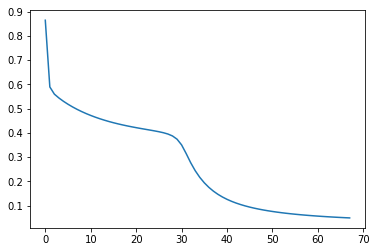

{'iterations': 68, 'cost_function': array([[ 0.04958664]])}
[[ 0.01220273  0.95827161  0.95016051  0.05815676]]
[array([[-3.29388938,  2.64675614],
       [ 1.70522303, -2.64034303],
       [-2.2292173 , -1.73490183]]), array([[ 3.5237224 ,  3.48321649, -2.70213352]])]


In [109]:
mlp = MultiLayerPerceptron(L=2, n=[2, 3, 1], g=["tanh", "sigmoid"], alpha=2, lambd=0.005)
#mlp = MultiLayerPerceptron(L=1, n=[2, 1], g=["sigmoid"], alpha=0.1)

X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

Y = np.array([[0],
              [1],
              [1],
              [0]])

res = mlp.learning(X.T, Y.T, 4, max_iter=5000, plot=True)
print(res)
print(mlp.get_output())
print(mlp.get_weights())
#mlp.set_all_training_examples(X.T, Y.T, 4)
#mlp.prepare()
#print(mlp.propagate())
#for i in range(100):
#    print(mlp.back_propagation())
#    mlp.propagate()
#print(mlp.propagate())
